In [1]:
from functools import partial

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PowerTransformer

from statsmodels.tsa.stattools import adfuller

In [2]:
TIME_STEPS = 250

WINDOWS = [12,]

In [29]:
def get_rolling(series, window, function):
    rolling = []
    for idx in range(window, len(series)):
        rolling.append([idx,function(series[idx-window:idx])])
    return np.array(rolling)

def get_periodic(series, period, function):
    periodic = [function(series[idx::period]) for idx in range(period)]
    return np.resize(periodic, len(series))
    

def get_rolling_averaged(series, window):
    rolling = []
    weights = np.arange(window) ** 2
    for idx in range(window, len(series)):
        rolling.append([idx,np.average(series[idx-window:idx], weights=weights)])
    return np.array(rolling)

def plot_series(series):
    print(f'Average Mean {series.mean()}')
    print(f'Average Variance {series.std()}')
    
    third = int(len(series)*0.3333)
    base_mean = series[:third].mean()
    base_std = series[:third].std()
    print(f'Third 1 Mean {base_mean}, Std {base_std}')
    for idx in range(1,3):
        mean, std = series[third*idx:third*(idx+1)].mean(), series[third*idx:third*(idx+1)].std()
        print(f'Third {idx} Mean {mean} ({(100*(mean-base_mean))/base_mean:.2f}% from base), Std {std} ({(100*(mean-base_std))/base_std:.2f}% from base)')
        
    fig, axs = plt.subplots(2,1,figsize=(15,6))
    axs[0].plot(np.arange(len(series)), series, label='series')
    for win in WINDOWS:
        data = get_rolling(series, win, np.mean)
        axs[0].plot(data[:,0], data[:,1], label=f'rolling-mean-{win}')
    for win in WINDOWS:
        data = get_rolling(series, win, np.std)
        axs[0].plot(data[:,0], data[:,1], label=f'rolling-std-{win}')
    axs[0].legend(loc='best')
    
    axs[1].hist(data[:,1], density=True, bins=30)  # density=False would make counts
    axs[1].set_ylabel('Probability')
    axs[1].set_xlabel('Data');
    
    plt.show()
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

# Linear Trend Time Series

## Additive

### Plain Series

Here is just a plan sereis generated using white noise with an additive trend.

Average Mean 65.53960511446424
Average Variance 36.15952959651127
Third 1 Mean 23.81078338006629, Std 13.21954291113593
Third 1 Mean 65.83968584312116 (176.51% from base), Std 12.656669768413348 (398.05% from base)
Third 2 Mean 106.11614675636737 (345.66% from base), Std 12.458800663132493 (702.72% from base)


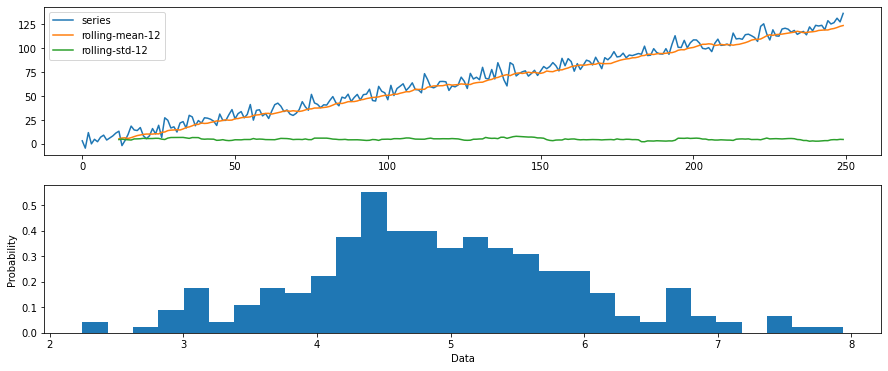

Results of Dickey-Fuller Test:
Test Statistic                  -0.054042
p-value                          0.953828
#Lags Used                       8.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


In [8]:
noise = np.random.normal(scale=5.0,size=(TIME_STEPS,))
trend = 0.5 * np.arange(TIME_STEPS) + 4
additive_linear_trend_series = trend + noise
plot_series(additive_linear_trend_series)

### Removing the rolling mean

Average Mean 3.30226426823944
Average Variance 5.176464842954614
Third 1 Mean 3.35452299957885, Std 5.133135005405158
Third 1 Mean 3.0595960246531475 (-8.79% from base), Std 5.540678519694727 (-40.40% from base)
Third 2 Mean 3.373914074109556 (0.58% from base), Std 4.7431424662394335 (-34.27% from base)


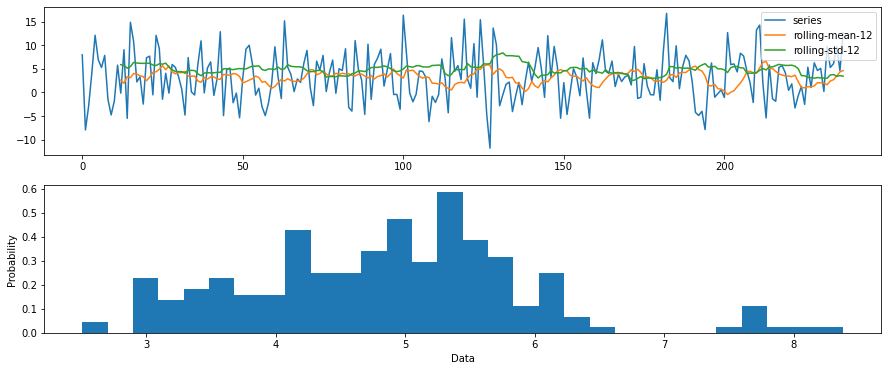

Results of Dickey-Fuller Test:
Test Statistic                -6.540565e+00
p-value                        9.369715e-09
#Lags Used                     1.500000e+01
Number of Observations Used    2.220000e+02
Critical Value (1%)           -3.460154e+00
Critical Value (5%)           -2.874649e+00
Critical Value (10%)          -2.573757e+00
dtype: float64


In [9]:
window = 12
trend = get_rolling(additive_linear_trend_series, window, np.mean)
detrended_series = additive_linear_trend_series[window:] - trend[:,1]
plot_series(detrended_series)

(238, 2)
Average Mean 1.7389932713106913
Average Variance 5.3137498810210495
Third 1 Mean 1.7463410792178238, Std 5.4706684473103
Third 1 Mean 1.585414688777788 (-9.22% from base), Std 5.772776779717471 (-71.02% from base)
Third 2 Mean 1.78755444781182 (2.36% from base), Std 4.586115794316469 (-67.32% from base)


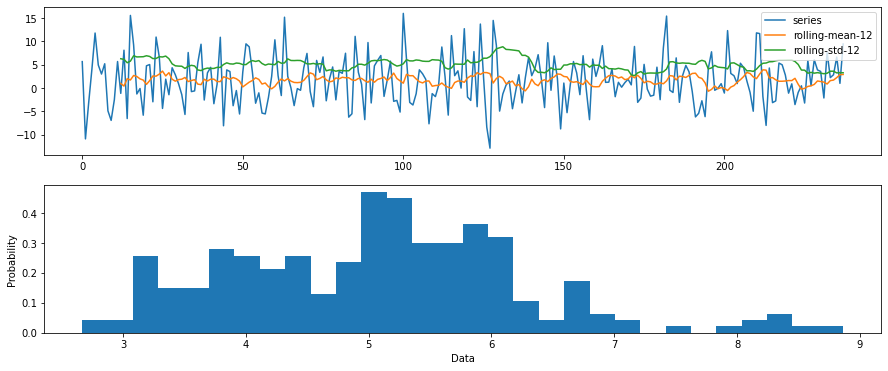

Results of Dickey-Fuller Test:
Test Statistic                -1.366012e+01
p-value                        1.527086e-25
#Lags Used                     1.000000e+00
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


In [10]:
window = 12
trend = get_rolling_averaged(additive_linear_trend_series, window)
detrended_series = additive_linear_trend_series[window:] - trend[:,1]
plot_series(detrended_series)

### Differencing the series

Average Mean 0.5343510700182186
Average Variance 6.8227396173759995
Third 1 Mean 0.5631339935913023, Std 7.059756357861374
Third 1 Mean 0.40206831674769966 (-28.60% from base), Std 7.674662532148255 (-94.30% from base)
Third 2 Mean 0.5391903648780784 (-4.25% from base), Std 5.5942672058635186 (-92.36% from base)


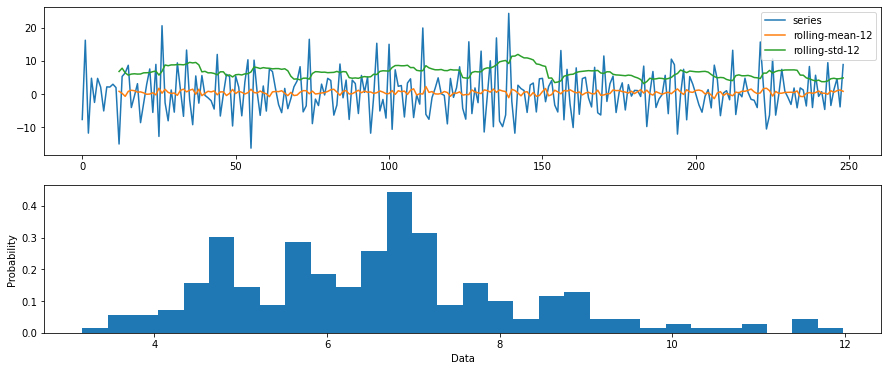

Results of Dickey-Fuller Test:
Test Statistic                -9.748277e+00
p-value                        8.144439e-17
#Lags Used                     7.000000e+00
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


In [11]:
differenced_series = np.diff(additive_linear_trend_series, 1)
plot_series(differenced_series)

Average Mean -7.133963210442772e-18
Average Variance 0.9999999999999999
Third 1 Mean 0.004218675369023321, Std 1.0347392328855325
Third 1 Mean -0.019388509702704167 (-559.59% from base), Std 1.1248652246089823 (-101.87% from base)
Third 2 Mean 0.000709289102508782 (-83.19% from base), Std 0.8199444093712978 (-99.93% from base)


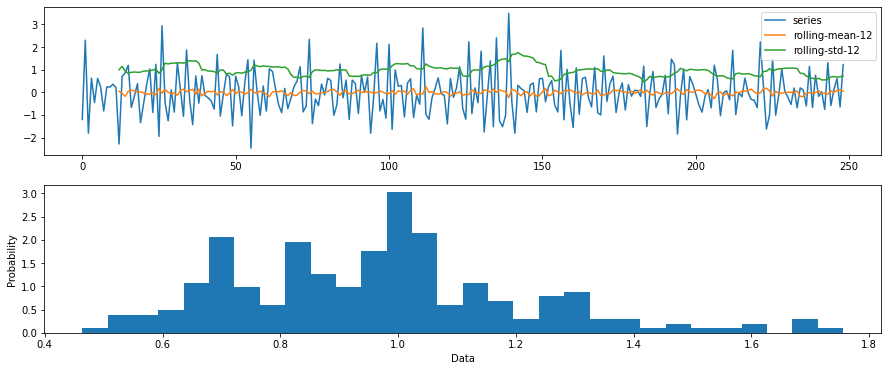

Results of Dickey-Fuller Test:
Test Statistic                -9.748277e+00
p-value                        8.144439e-17
#Lags Used                     7.000000e+00
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


In [12]:
differenced_series = np.diff(additive_linear_trend_series, 1)
differenced_series = (differenced_series - np.mean(differenced_series)) / np.std(differenced_series)
plot_series(differenced_series)

## Multiplicative

### Plain Series

Average Mean 1985.8161023510431
Average Variance 1139.1233329166225
Third 1 Mean 731.6928440803609, Std 380.18056532929364
Third 1 Mean 1950.370122105579 (166.56% from base), Std 449.5087643996522 (413.01% from base)
Third 2 Mean 3250.9290825889075 (344.30% from base), Std 581.0411701958254 (755.10% from base)


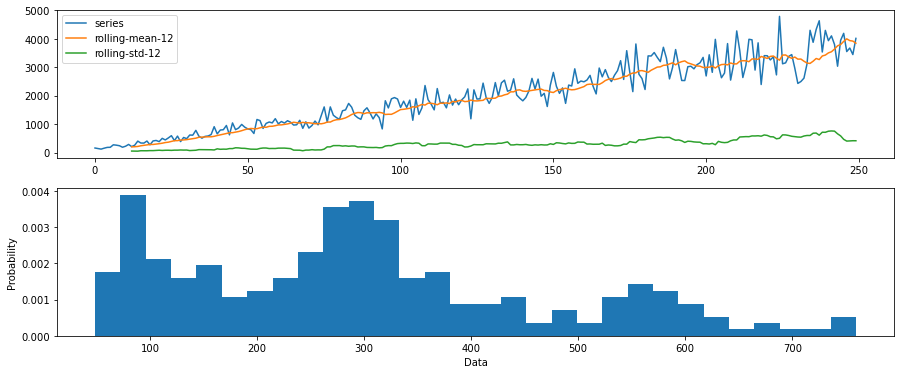

Results of Dickey-Fuller Test:
Test Statistic                  -0.401444
p-value                          0.909857
#Lags Used                      12.000000
Number of Observations Used    237.000000
Critical Value (1%)             -3.458247
Critical Value (5%)             -2.873814
Critical Value (10%)            -2.573311
dtype: float64


In [13]:
noise = np.random.normal(loc=30,scale=5.0,size=(TIME_STEPS,))
trend = 0.5 * np.arange(TIME_STEPS) + 4
multiplicative_linear_trend_series = trend * noise
plot_series(series)

### Removing the rolling mean

Average Mean 1.0841533910296224
Average Variance 0.19897415538569313
Third 1 Mean 1.1669546951774439, Std 0.21661215966373332
Third 1 Mean 1.053336346732168 (-9.74% from base), Std 0.1747438990440561 (386.28% from base)
Third 2 Mean 1.0326783753408766 (-11.51% from base), Std 0.17703424353597694 (376.74% from base)


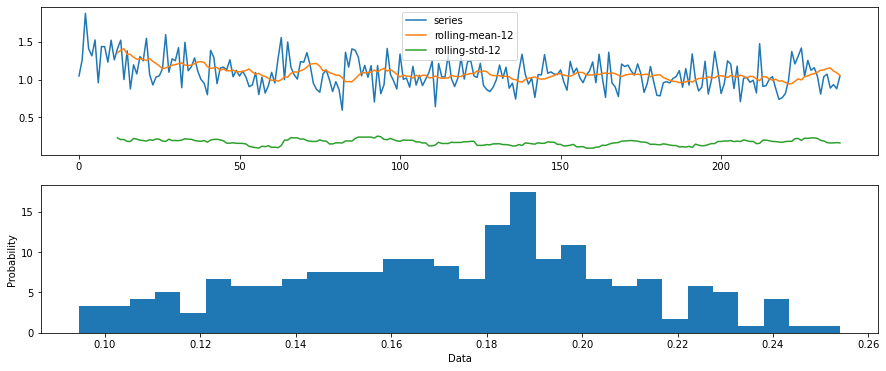

Results of Dickey-Fuller Test:
Test Statistic                -8.095709e+00
p-value                        1.340884e-12
#Lags Used                     1.000000e+00
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


In [14]:
window = 12
trend = get_rolling(series, window, np.mean)
detrended_series = series[window:] / trend[:,1]
plot_series(detrended_series)

(238, 2)
Average Mean 1.0443816390176521
Average Variance 0.18462728055777436
Third 1 Mean 1.0828006472740435, Std 0.19023936794055896
Third 1 Mean 1.0311639931881917 (-4.77% from base), Std 0.17924930073016182 (442.04% from base)
Third 2 Mean 1.0185744399641863 (-5.93% from base), Std 0.17895842904784343 (435.42% from base)


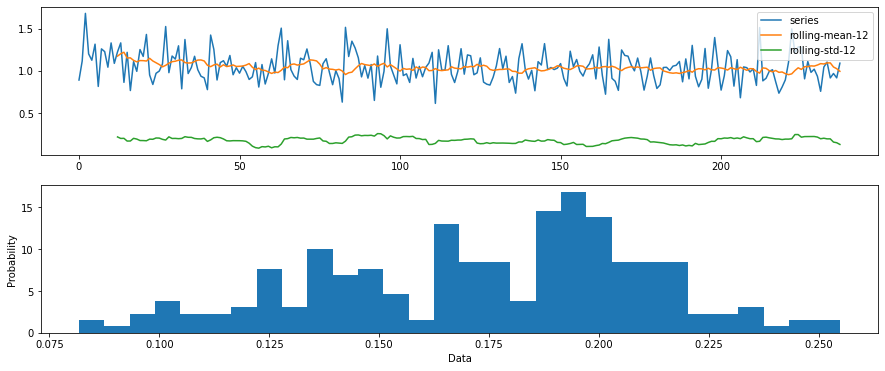

Results of Dickey-Fuller Test:
Test Statistic                -1.586985e+01
p-value                        9.008184e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


In [15]:
window = 12
trend = get_rolling_averaged(series, window)
print(trend.shape)
detrended_series = series[window:] / trend[:,1]
plot_series(detrended_series)

### Differencing the series

Average Mean 15.487692927193816
Average Variance 483.9449183787276
Third 1 Mean 16.36022741707113, Std 175.9982991264576
Third 1 Mean 6.841705703380848 (-58.18% from base), Std 409.72834507583667 (-96.11% from base)
Third 2 Mean 18.178698878954254 (11.12% from base), Std 712.4795295749243 (-89.67% from base)


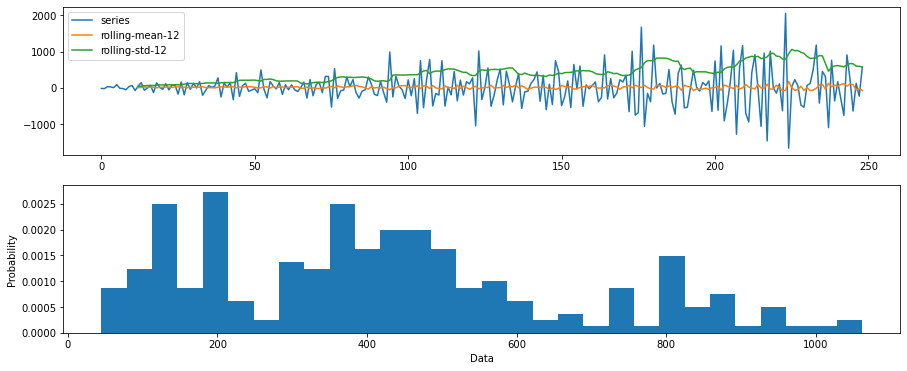

Results of Dickey-Fuller Test:
Test Statistic                -8.828323e+00
p-value                        1.798127e-14
#Lags Used                     1.100000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


In [16]:
differenced_series = np.diff(series, 1)
plot_series(differenced_series)

Average Mean -9.809199414358813e-18
Average Variance 1.0
Third 1 Mean 0.001802962396630606, Std 0.3636742373823711
Third 1 Mean -0.017865643166123196 (-1090.90% from base), Std 0.8466425196662355 (-104.91% from base)
Third 2 Mean 0.005560562472224332 (208.41% from base), Std 1.4722326911951353 (-98.47% from base)


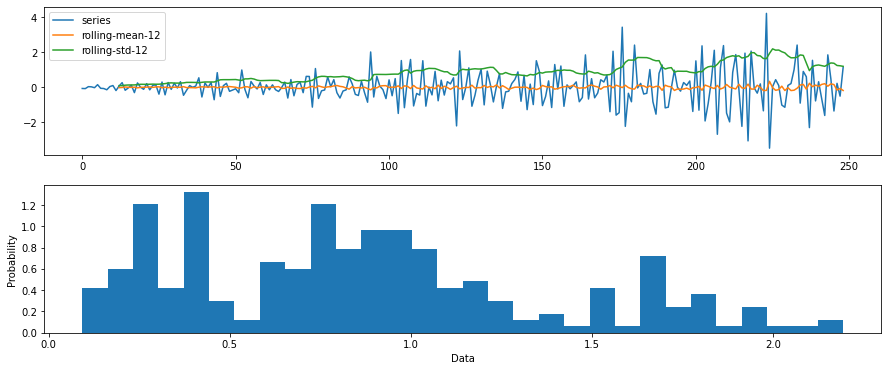

Results of Dickey-Fuller Test:
Test Statistic                -8.828323e+00
p-value                        1.798127e-14
#Lags Used                     1.100000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


In [17]:
differenced_series = np.diff(series, 1)
differenced_series = (differenced_series - np.mean(differenced_series)) / np.std(differenced_series)
plot_series(differenced_series)

Average Mean -0.00027209159730042523
Average Variance 1.2421128893276427
Third 1 Mean -0.021783923710197817, Std 1.2256956146493763
Third 1 Mean -0.025466691264085656 (16.91% from base), Std 1.2667828026608805 (-102.08% from base)
Third 2 Mean 0.03273890564667381 (-250.29% from base), Std 1.234324912291912 (-97.33% from base)


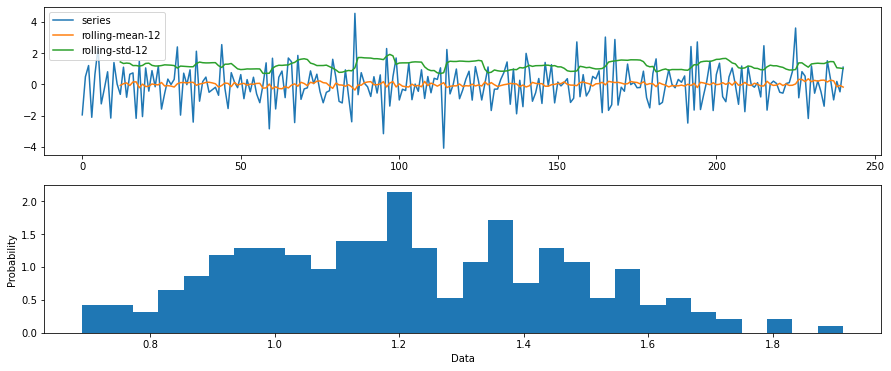

Results of Dickey-Fuller Test:
Test Statistic                -1.063359e+01
p-value                        5.139709e-19
#Lags Used                     4.000000e+00
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


In [18]:
window = 8
differenced_series = np.diff(series, 1)
differenced_series = (differenced_series - np.mean(differenced_series)) / np.std(differenced_series)
variance_trend = get_rolling(differenced_series, window, np.std)
detrended_series = differenced_series[window:] / variance_trend[:,1]
plot_series(detrended_series)

Power Transformer Lambdas:  [0.63107615]
Average Mean -2.842170943040401e-16
Average Variance 0.9999999999999999
Third 1 Mean -1.1512071983394714, Std 0.4741957558551813
Third 1 Mean 0.07296789217752414 (-106.34% from base), Std 0.3808647737783416 (-84.61% from base)
Third 2 Mean 1.0591935837493573 (-192.01% from base), Std 0.39940937061803244 (123.37% from base)


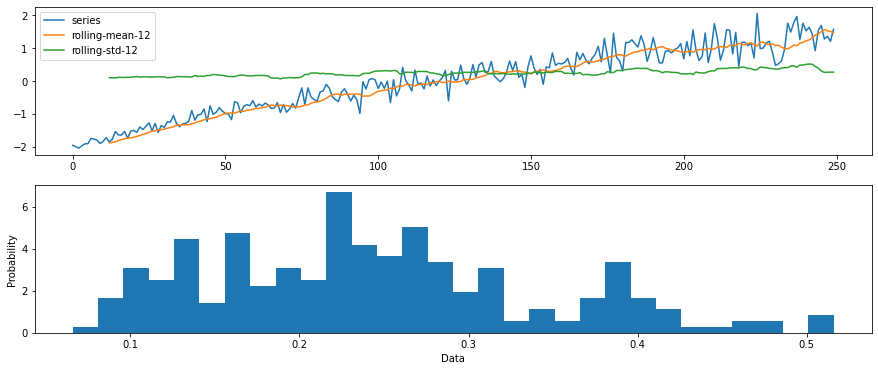

Results of Dickey-Fuller Test:
Test Statistic                  -1.752695
p-value                          0.404187
#Lags Used                      12.000000
Number of Observations Used    237.000000
Critical Value (1%)             -3.458247
Critical Value (5%)             -2.873814
Critical Value (10%)            -2.573311
dtype: float64


In [19]:
scaler = PowerTransformer(method='yeo-johnson')
normalized_series = scaler.fit_transform(series.reshape(-1,1)).flatten()
print("Power Transformer Lambdas: ", scaler.lambdas_)
plot_series(normalized_series)

Power Transformer Lambdas:  [0.63117465]
Average Mean -1.7053025658242405e-16
Average Variance 1.0
Third 1 Mean -1.1512156492858099, Std 0.47433456389696516
Third 1 Mean 0.07302288513230118 (-106.34% from base), Std 0.3808347149369604 (-84.61% from base)
Third 2 Mean 1.0591483087905178 (-192.00% from base), Std 0.39936387541837104 (123.29% from base)


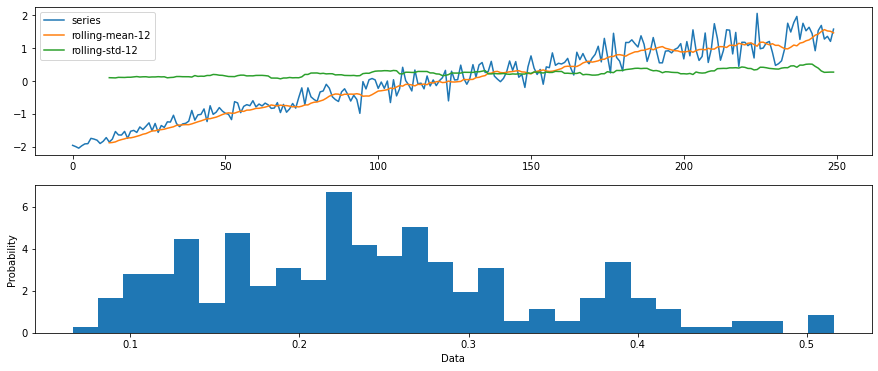

Results of Dickey-Fuller Test:
Test Statistic                  -1.754079
p-value                          0.403486
#Lags Used                      12.000000
Number of Observations Used    237.000000
Critical Value (1%)             -3.458247
Critical Value (5%)             -2.873814
Critical Value (10%)            -2.573311
dtype: float64


In [20]:
scaler = PowerTransformer(method='box-cox')
normalized_series = scaler.fit_transform(series.reshape(-1,1)).flatten()
print("Power Transformer Lambdas: ", scaler.lambdas_)
plot_series(normalized_series)

Power Transformer Lambdas:  [0.63107615]
Average Mean 1.5159671822190893e-17
Average Variance 1.0
Third 1 Mean 0.01638658935528428, Std 0.5363556419550481
Third 1 Mean -0.02273751085507695 (-238.76% from base), Std 0.9598621792676624 (-104.24% from base)
Third 2 Mean -0.002355706709533139 (-114.38% from base), Std 1.3460633207142778 (-100.44% from base)


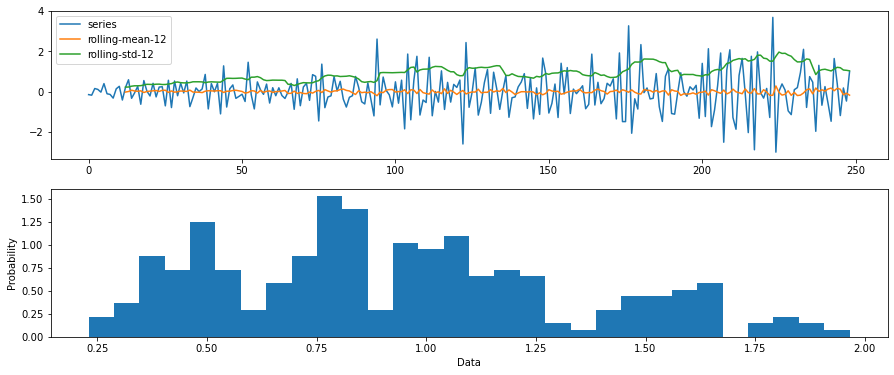

Results of Dickey-Fuller Test:
Test Statistic                -8.431021e+00
p-value                        1.870087e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


In [21]:
scaler = PowerTransformer(method='yeo-johnson')
normalized_series = scaler.fit_transform(series.reshape(-1,1)).flatten()
print("Power Transformer Lambdas: ", scaler.lambdas_)
differenced_series = np.diff(normalized_series, 1)
differenced_series = (differenced_series - np.mean(differenced_series)) / np.std(differenced_series)
plot_series(differenced_series)

Power Transformer Lambdas:  [0.63117465]
Average Mean 1.4267926420885545e-17
Average Variance 1.0
Third 1 Mean 0.016402033407881742, Std 0.5364692392281578
Third 1 Mean -0.022744356956477682 (-238.67% from base), Std 0.9598654557431225 (-104.24% from base)
Third 2 Mean -0.0023636722169735986 (-114.41% from base), Std 1.3460158676278426 (-100.44% from base)


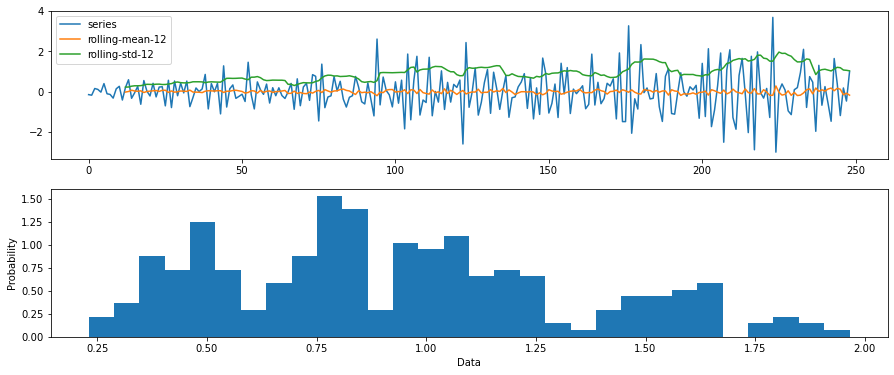

Results of Dickey-Fuller Test:
Test Statistic                -8.430425e+00
p-value                        1.876652e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


In [22]:
scaler = PowerTransformer(method='box-cox')
normalized_series = scaler.fit_transform(series.reshape(-1,1)).flatten()
print("Power Transformer Lambdas: ", scaler.lambdas_)
differenced_series = np.diff(normalized_series, 1)
differenced_series = (differenced_series - np.mean(differenced_series)) / np.std(differenced_series)
plot_series(differenced_series)

# No Trend Seasonal Time Series

## Additive Seasonality

### Plain series

Average Mean 0.14838696335959395
Average Variance 5.680669040318471
Third 1 Mean -0.08744389779537466, Std 5.722057782749855
Third 1 Mean 0.37626495889917483 (-530.29% from base), Std 5.409891913515883 (-93.42% from base)
Third 2 Mean 0.18833434199694393 (-315.38% from base), Std 5.915726364268067 (-96.71% from base)


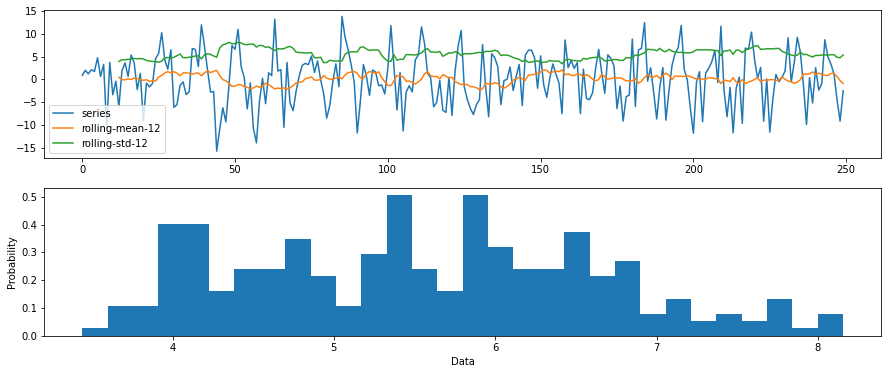

Results of Dickey-Fuller Test:
Test Statistic                  -3.101394
p-value                          0.026450
#Lags Used                      16.000000
Number of Observations Used    233.000000
Critical Value (1%)             -3.458731
Critical Value (5%)             -2.874026
Critical Value (10%)            -2.573424
dtype: float64


In [28]:
noise = np.random.normal(scale=5.0,size=(TIME_STEPS,))
seasonality = 5.0 * np.sin((2*np.arange(TIME_STEPS)/12)*np.pi)
series = seasonality + noise
plot_series(series)

### Removing seasonal mean

Average Mean -7.815970093361102e-17
Average Variance 4.392278819448395
Third 1 Mean -0.23994201964298265, Std 4.051891620547831
Third 1 Mean 0.215339148747716 (-189.75% from base), Std 4.73541824830237 (-94.69% from base)
Third 2 Mean -0.0053501211094367585 (-97.77% from base), Std 4.369018798571539 (-100.13% from base)


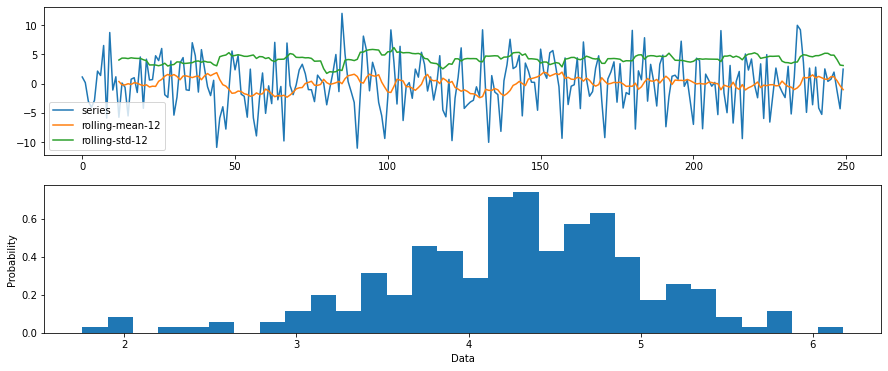

Results of Dickey-Fuller Test:
Test Statistic                -1.632653e+01
p-value                        3.090634e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


In [31]:
seasonality = get_periodic(series, 12, np.mean)
deseasonalized_series = series - seasonality
plot_series(deseasonalized_series)

### Differencing the series